In [1]:
import pandas as pd
import numpy as np

In [2]:
fake = pd.read_csv('../input/fake-and-real-news-dataset/Fake.csv')
true = pd.read_csv('../input/fake-and-real-news-dataset/True.csv')

fake['target'] = 0
true['target'] = 1

In [3]:
fake.shape

(23481, 5)

In [4]:
true.shape

(21417, 5)

In [5]:
news = pd.concat([true, fake], ignore_index = True)
news['text'] = news['title'] + " " + news['text']
news.shape

(44898, 5)

In [6]:
news[21416:21420]

,title,text,subject,date,target
21416,Indonesia to buy $1.14 billion worth of Russia...,Indonesia to buy $1.14 billion worth of Russia...,worldnews,"August 22, 2017",1
21417,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump Sends Out Embarrassing New Year’...,News,"December 31, 2017",0
21418,Drunk Bragging Trump Staffer Started Russian ...,Drunk Bragging Trump Staffer Started Russian ...,News,"December 31, 2017",0
21419,Sheriff David Clarke Becomes An Internet Joke...,Sheriff David Clarke Becomes An Internet Joke...,News,"December 30, 2017",0


In [7]:
news['text'].head(20)

0     As U.S. budget fight looms, Republicans flip t...
1     U.S. military to accept transgender recruits o...
2     Senior U.S. Republican senator: 'Let Mr. Muell...
3     FBI Russia probe helped by Australian diplomat...
4     Trump wants Postal Service to charge 'much mor...
5     White House, Congress prepare for talks on spe...
6     Trump says Russia probe will be fair, but time...
7     Factbox: Trump on Twitter (Dec 29) - Approval ...
8     Trump on Twitter (Dec 28) - Global Warming The...
9     Alabama official to certify Senator-elect Jone...
10    Jones certified U.S. Senate winner despite Moo...
11    New York governor questions the constitutional...
12    Factbox: Trump on Twitter (Dec 28) - Vanity Fa...
13    Trump on Twitter (Dec 27) - Trump, Iraq, Syria...
14    Man says he delivered manure to Mnuchin to pro...
15    Virginia officials postpone lottery drawing to...
16    U.S. lawmakers question businessman at 2016 Tr...
17    Trump on Twitter (Dec 26) - Hillary Clinto

In [8]:
import re
import nltk
from nltk.corpus import stopwords
import string
from string import punctuation

stop = set(stopwords.words('english'))
punctuations = list(string.punctuation)
stop.update(punctuation)

def preprocess_text(df):
    df['text'] = df['text'].str.replace('\[[^]]*\]', '')
    df['text'] = df['text'].apply(lambda x : x.lower())
    df['text'] = df['text'].apply(lambda x : x.split(" "))
    df['text'] = df['text'].apply(lambda x : [word for word in x if word not in stop])
    df['text'] = df['text'].apply(lambda x : " ".join(x))
    df['text'] = df['text'].str.replace('https?:\/\/.*[\r\n]*', '')
    df['text'] = df['text'].str.replace('[^\w\s]', '')
    
    return df

news = preprocess_text(news)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: FutureWarning: The default value of regex will change from True to False in a future version.
  if sys.path[0] == '':
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:17: FutureWarning: The default value of regex will change from True to False in a future version.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:18: FutureWarning: The default value of regex will change from True to False in a future version.


In [9]:
empty_text = [index for index,text in enumerate(news.text.values) if str(text).strip() == '']
len(empty_text)

9

In [10]:
news = news.drop(empty_text)
news = news.drop(['title'], axis = 1)
news.shape

(44889, 4)

In [11]:
news['text'].apply(lambda x : len(str(x).split())).max()

4974

In [12]:
import tensorflow as tf
import keras
from keras.preprocessing.text import Tokenizer

t = Tokenizer()
t.fit_on_texts(news['text'])
News_seq = t.texts_to_sequences(news['text'])
# X_test_seq = t.texts_to_sequences(X_test)

In [13]:
len(t.word_index)

216766

In [14]:
from keras.preprocessing import sequence

News_pad = sequence.pad_sequences(News_seq, maxlen = 1000)
# X_test_pad = sequence.pad_sequences(X_test_seq, maxlen = 1000)

Source : https://towardsdatascience.com/light-on-math-ml-intuitive-guide-to-understanding-glove-embeddings-b13b4f19c010

Glove captures the global and local statistics of words in a corpus while Word2Vec only considers local statistics. 
Given a corpus having V words, the co-occurrence matrix X will be a V x V matrix, where the i th row and j th column of X, X_ij denotes how many times word i has co-occurred with word j. An example co-occurrence matrix might look as follows.

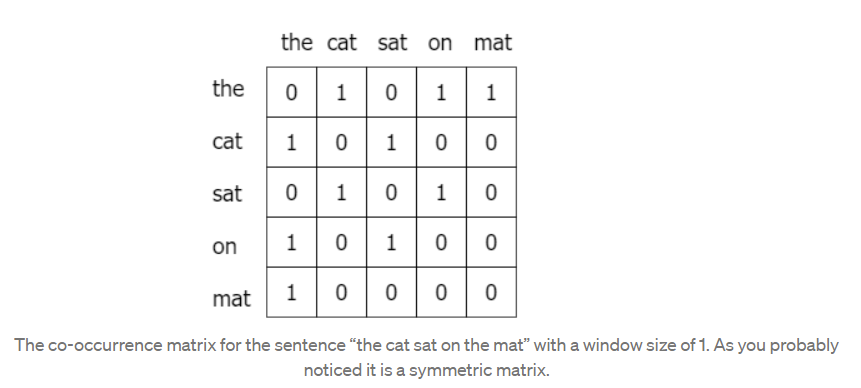

How do we get a metric that measures semantic similarity between words from this? For that, you will need three words at a time. Let me concretely lay down this statement.

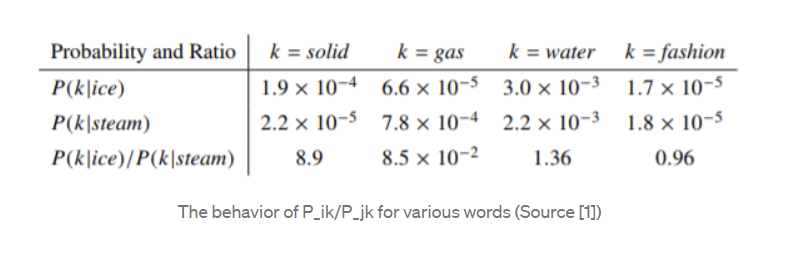

P_ik/P_jk where P_ik = X_ik/X_i
Here P_ik denotes the probability of seeing word i and k together, which is computed by dividing the number of times i and k appeared together (X_ik) by the total number of times word i appeared in the corpus (X_i).
You can see that given two words, i.e. ice and steam, if the third word k (also called the “probe word”),

- is very similar to ice but irrelevant to steam (e.g. k=solid), P_ik/P_jk will be very high (>1),
- is very similar to steam but irrelevant to ice (e.g. k=gas), P_ik/P_jk will be very small (<1),
- is related or unrelated to either words, then P_ik/P_jk will be close to 1

So, if we can find a way to incorporate P_ik/P_jk to computing word vectors we will be achieving the goal of using global statistics when learning word vectors.

In [15]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(News_pad, news['target'], test_size = 0.3, random_state = 2021, stratify = news['target'], shuffle = True)

In [16]:
import os, gc

del News_pad, news, fake, true, News_seq
gc.collect()

84

In [17]:
embedding_words = {}
file = open('../input/glove840b300dtxt/glove.840B.300d.txt', 'r', encoding = 'utf-8')
for line in file:
    values = line.split(' ')
    word = values[0]
    vector = np.asarray([float(val) for val in values[1:]])
    embedding_words[word] = vector
file.close()

In [18]:
embedding_matrix = np.zeros((len(t.word_index) + 1, 300))
for word,val in t.word_index.items() :
    vector = embedding_words.get(word)
    if vector is not None:
        embedding_matrix[val] = vector

In [19]:
def model():
    model = keras.Sequential()
    model.add(keras.layers.Embedding(len(t.word_index) + 1, output_dim = 300, weights = [embedding_matrix], input_length = 1000, trainable = False ))
    model.add(keras.layers.LSTM(50, dropout = 0.4))
    model.add(keras.layers.Dense(1, activation = 'sigmoid'))
    return model

model = model()

2021-11-04 15:25:36.499547: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-04 15:25:36.614307: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-04 15:25:36.615025: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-04 15:25:36.617226: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [20]:
model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 1000, 300)         65030100  
_________________________________________________________________
lstm (LSTM)                  (None, 50)                70200     
_________________________________________________________________
dense (Dense)                (None, 1)                 51        
Total params: 65,100,351
Trainable params: 70,251
Non-trainable params: 65,030,100
_________________________________________________________________


In [21]:
history = model.fit(X_train, y_train, epochs = 5, batch_size = 128, validation_data = (X_test, y_test))

2021-11-04 15:25:39.941243: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 125688000 exceeds 10% of free system memory.
2021-11-04 15:25:40.089814: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/5


2021-11-04 15:25:42.455517: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


246/246 [==============================] - 21s 71ms/step - loss: 0.2442 - accuracy: 0.9039 - val_loss: 0.1549 - val_accuracy: 0.9474
Epoch 2/5
246/246 [==============================] - 17s 70ms/step - loss: 0.1772 - accuracy: 0.9376 - val_loss: 0.1382 - val_accuracy: 0.9547
Epoch 3/5
246/246 [==============================] - 17s 70ms/step - loss: 0.1158 - accuracy: 0.9626 - val_loss: 0.1547 - val_accuracy: 0.9521
Epoch 4/5
246/246 [==============================] - 17s 70ms/step - loss: 0.0855 - accuracy: 0.9706 - val_loss: 0.0814 - val_accuracy: 0.9656
Epoch 5/5
246/246 [==============================] - 17s 70ms/step - loss: 0.0855 - accuracy: 0.9684 - val_loss: 0.0361 - val_accuracy: 0.9892


In [22]:
from sklearn.metrics import roc_auc_score

pred_t = model.predict(X_test)
pred_t = pred_t.reshape(-1,)
print(roc_auc_score(y_test, pred_t))

0.9987767226546226


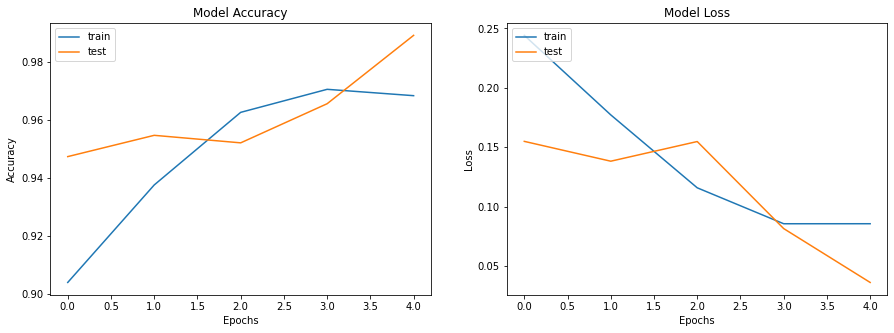

In [23]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 2)
fig.set_size_inches(15, 5)

ax[0].plot(history.history['accuracy'])
ax[0].plot(history.history['val_accuracy'])
ax[0].set_title('Model Accuracy')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')
ax[0].legend(['train', 'test'], loc = 'upper left')

ax[1].plot(history.history['loss'])
ax[1].plot(history.history['val_loss'])
ax[1].set_title('Model Loss')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss')
ax[1].legend(['train', 'test'], loc = 'upper left')

plt.show()

Reference notebooks :

https://www.kaggle.com/atishadhikari/fake-news-cleaning-word2vec-lstm-99-accuracy

https://www.kaggle.com/josutk/only-one-word-99-2

https://www.kaggle.com/madz2000/nlp-using-glove-embeddings-99-87-accuracy